In this notebook we will use the Bias Framework to explore bias and bias mitigation in classification problems. 

Before we apply the Bias Framework, we need to have such a classification problem to work on. We will use a dataset sourced from the United States census in 1994 which provides individual's characteristics and asks us to predict if their income is greater than $50,000 (according to google, equivalent to a little over $100,000 in 2024). 

There are a few reasons for choosing this dataset. It is publicly available (which mean you can run this notebook! Isn't that great?) and even sees some use in research. We get an interesting set of features, including obvious places to look for bias against a group. It's also real data, which is pretty cool and means there is more meaningful detail we can dig into. Hopefully companies aren't using data from 1994 to make decisions around race or gender, and the thing we are predicting isn't super important, but hopefully you will be able to image how this would apply today.





Reference: 
Becker,Barry and Kohavi,Ronny. (1996). Adult. UCI Machine Learning Repository. https://doi.org/10.24432/C5XW20.

In [1]:
from bias_framework import Bias_Framework
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import sweetviz as sv
seed = 0

pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'
/Users/daws/.local/share/virtualenvs/bias_framework-lO12qBfZ/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


If not done already, download data from https://archive.ics.uci.edu/dataset/2/adult 

Place the folder in this directory before running the following cell

In [2]:
# Data appears not to include column names, but these can be found in adult.names. 
# fnlwgt stands for final weight, and indicates the number of people the census believes the entry represents (https://cseweb.ucsd.edu/classes/sp15/cse190-c/reports/sp15/048.pdf)
df_census_income_train = pd.read_csv("./adult/adult.data", skipinitialspace=True, names=["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"])

df_census_income_validation = pd.read_csv("./adult/adult.test", skipinitialspace=True, skiprows=1, names=["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"])



In [3]:
df_census_income_train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
df_census_income_validation.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


In [5]:
df_census_income_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [6]:

df_census_income_train.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [7]:
for column in df_census_income_train.columns:
    unique_count_train = df_census_income_train[column].nunique()
    print(column + ",", unique_count_train, "unique values in training")
    unique_count_validation = df_census_income_validation[column].nunique()
    if unique_count_train == unique_count_validation:
        print("Which is the same in validation")
    else:
        print("While validation has", unique_count_validation)
    print("-------------------------------------------------")

age, 73 unique values in training
Which is the same in validation
-------------------------------------------------
workclass, 9 unique values in training
Which is the same in validation
-------------------------------------------------
fnlwgt, 21648 unique values in training
While validation has 12787
-------------------------------------------------
education, 16 unique values in training
Which is the same in validation
-------------------------------------------------
education-num, 16 unique values in training
Which is the same in validation
-------------------------------------------------
marital-status, 7 unique values in training
Which is the same in validation
-------------------------------------------------
occupation, 15 unique values in training
Which is the same in validation
-------------------------------------------------
relationship, 6 unique values in training
Which is the same in validation
-------------------------------------------------
race, 5 unique values in 

In [10]:
# sv requires that the target variable be numerical or boolean, so we map income to a boolean before finishing the data analysis]
# Also handles the small difference with income ending with a . in validation but no in training
df_census_income_train["high income"]  = df_census_income_train["income"] == ">50K"
df_census_income_train.drop("income", axis=1, inplace=True)
df_census_income_validation["high income"]  = df_census_income_validation["income"] == ">50K."
df_census_income_validation.drop("income", axis=1, inplace=True)

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)



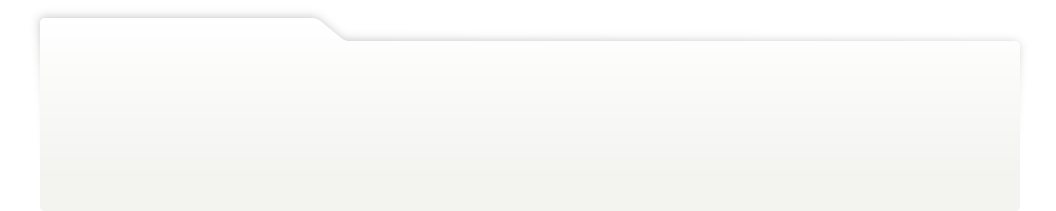
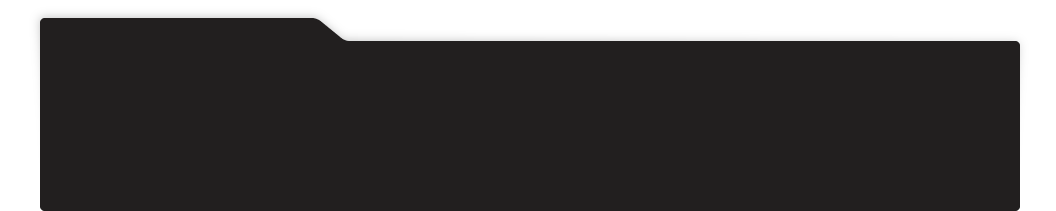
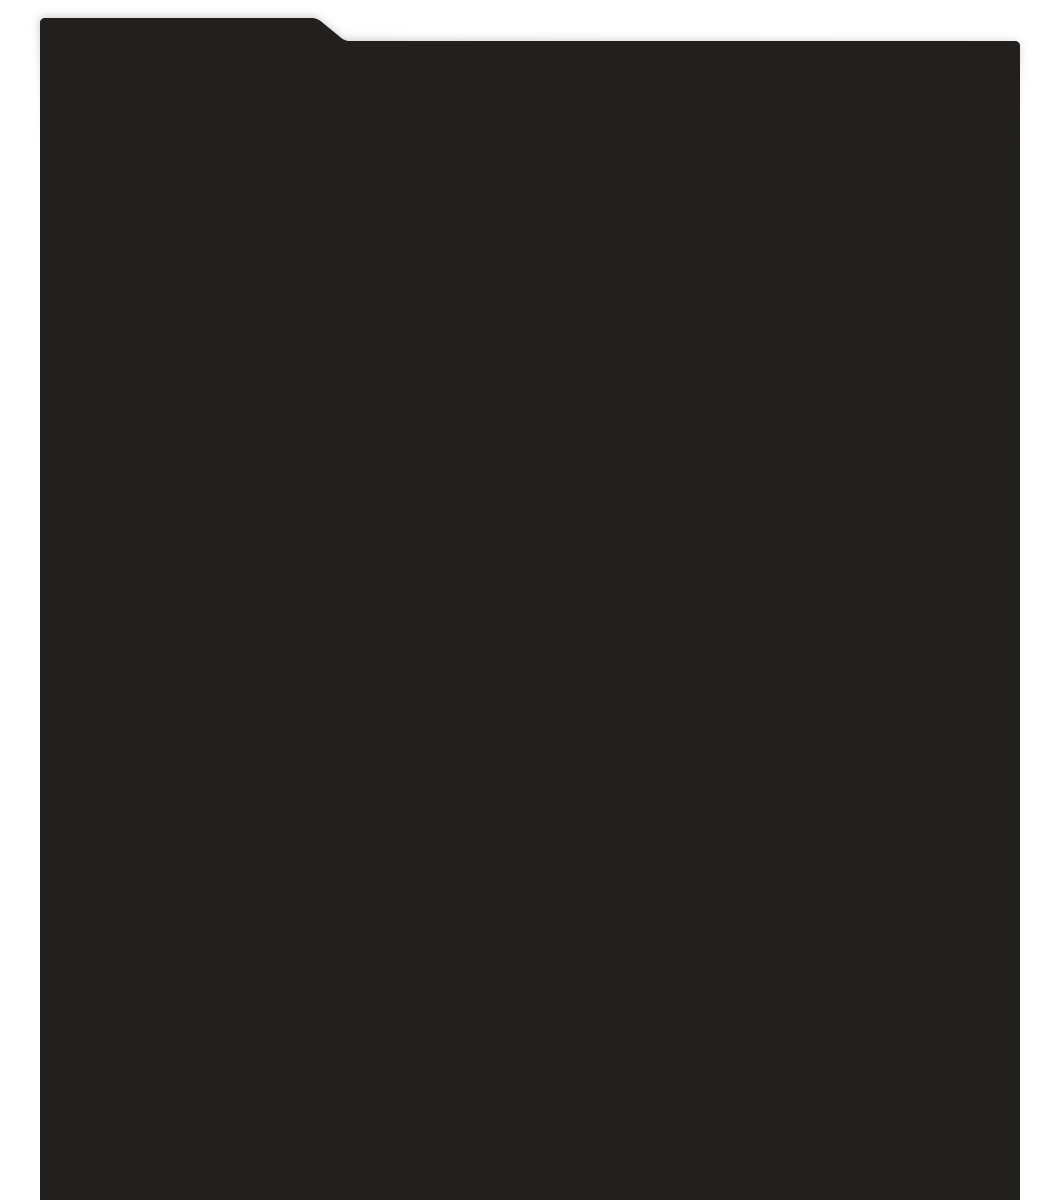
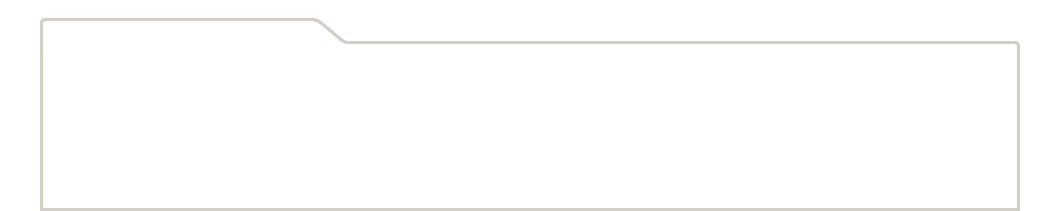
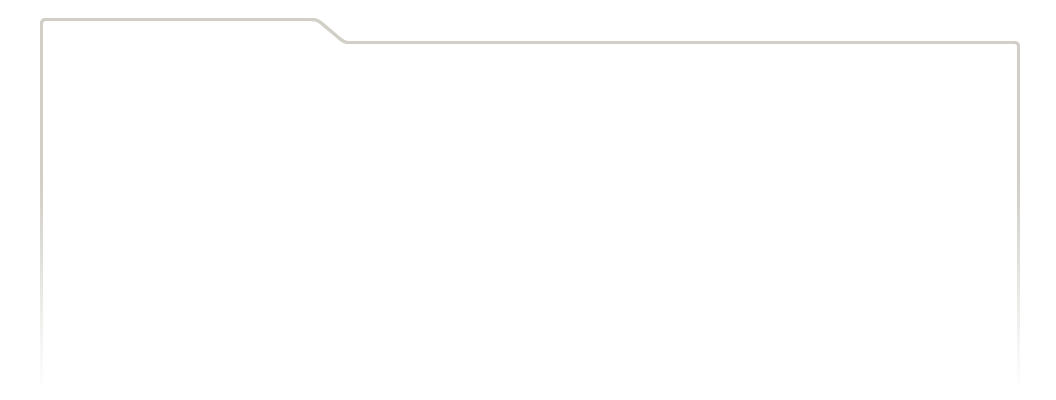
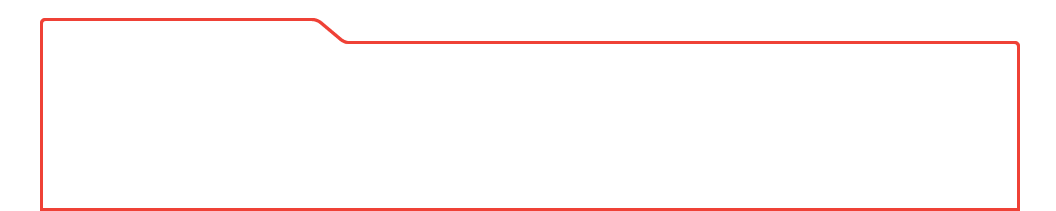
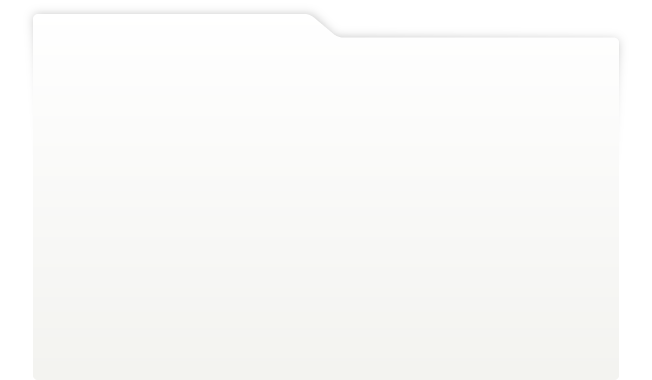
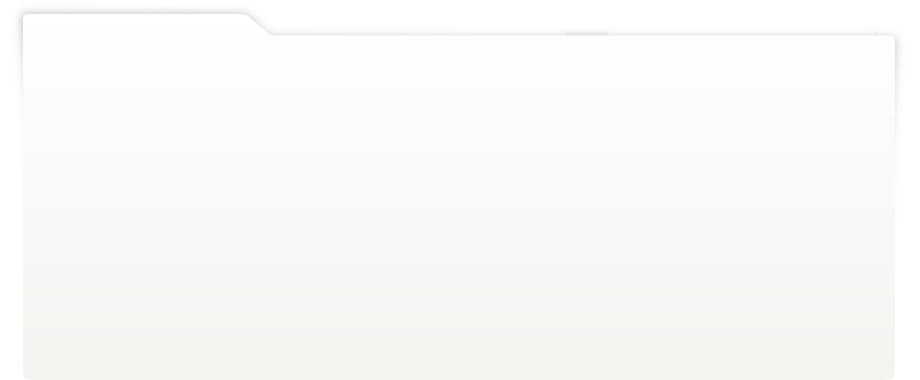
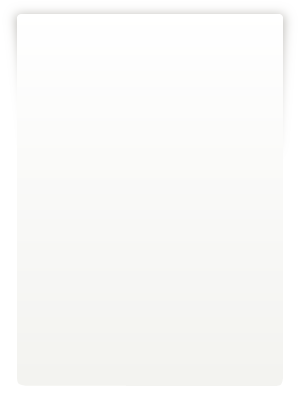
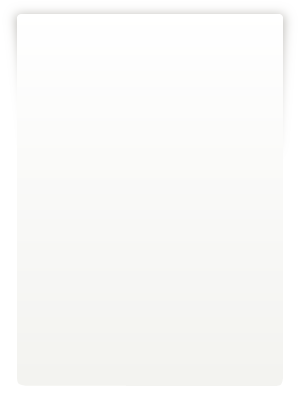
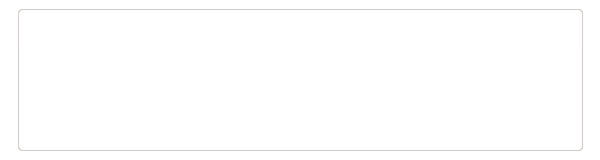
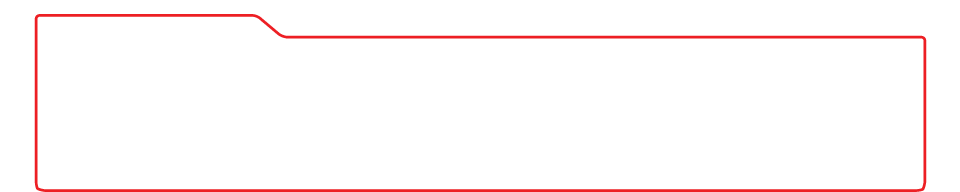
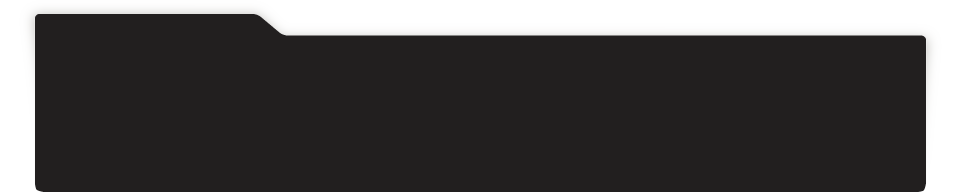
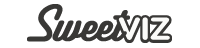
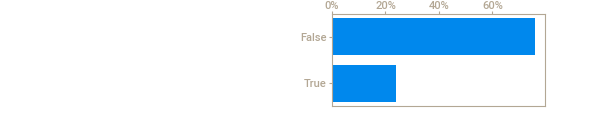
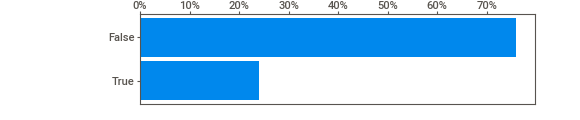
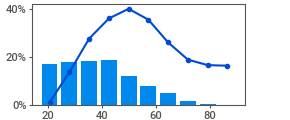
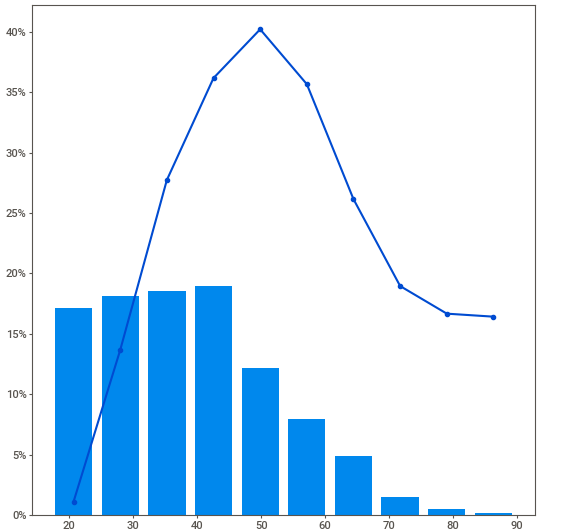
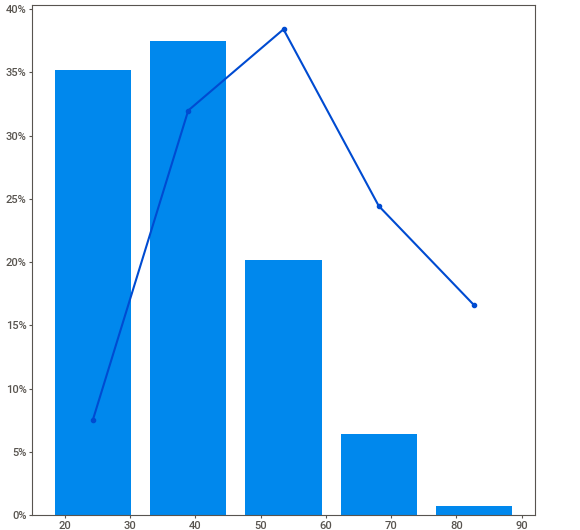
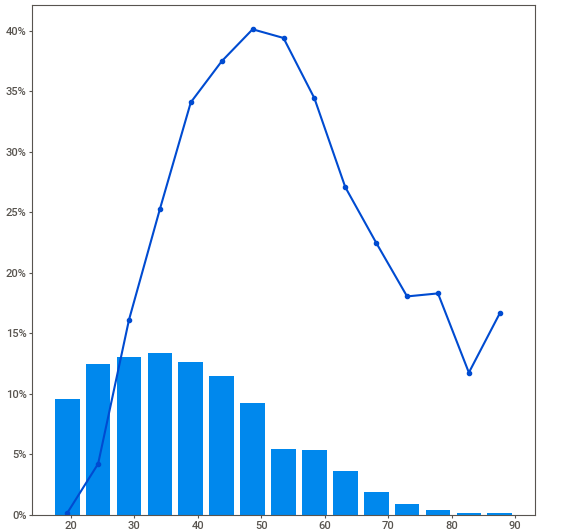
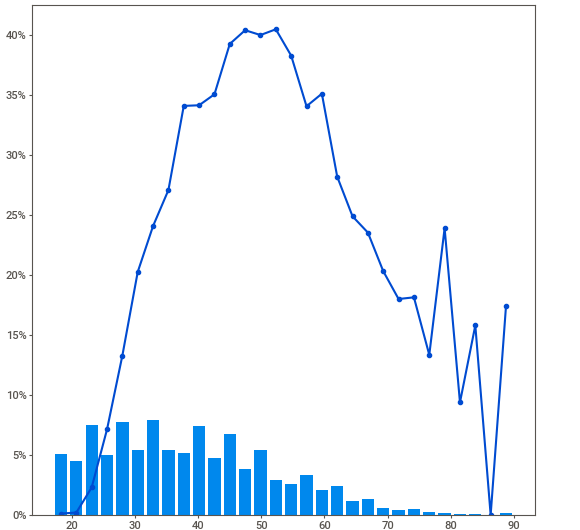
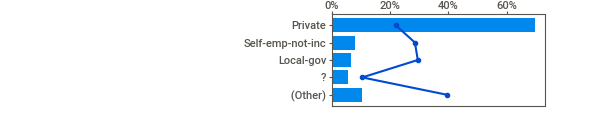
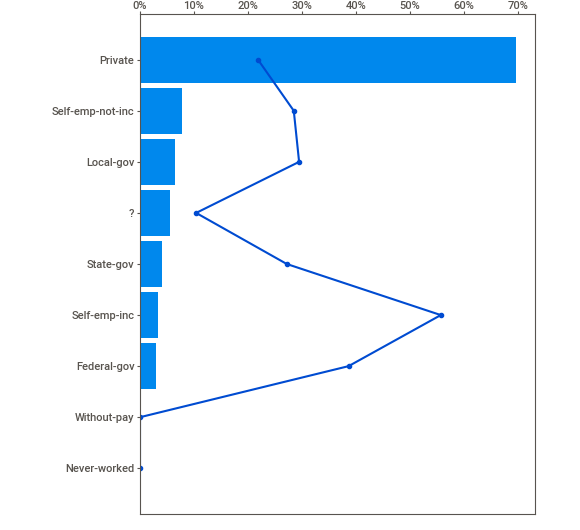
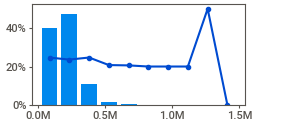
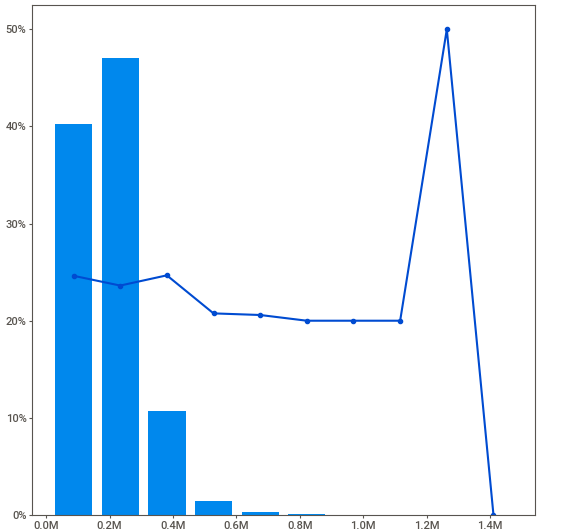
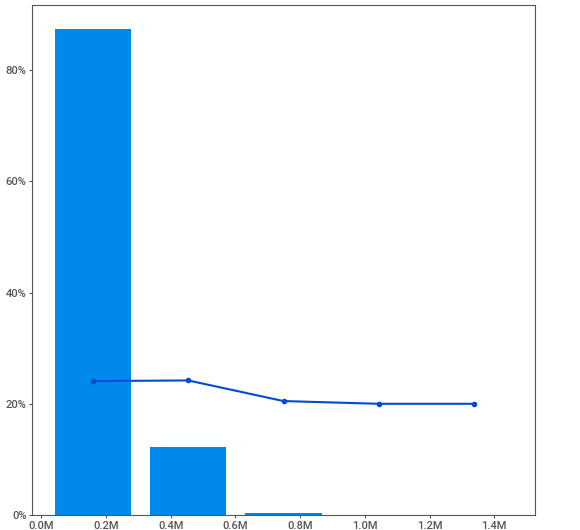
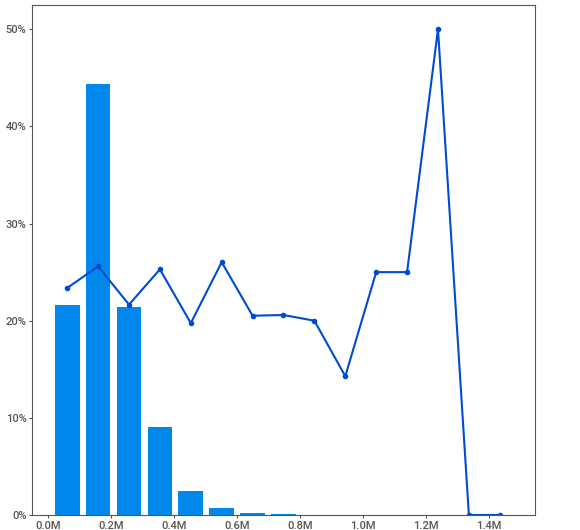
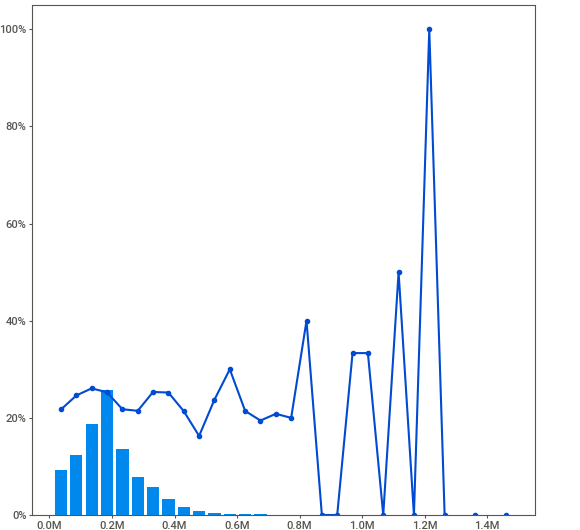
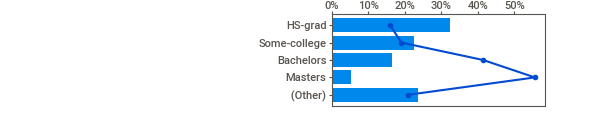
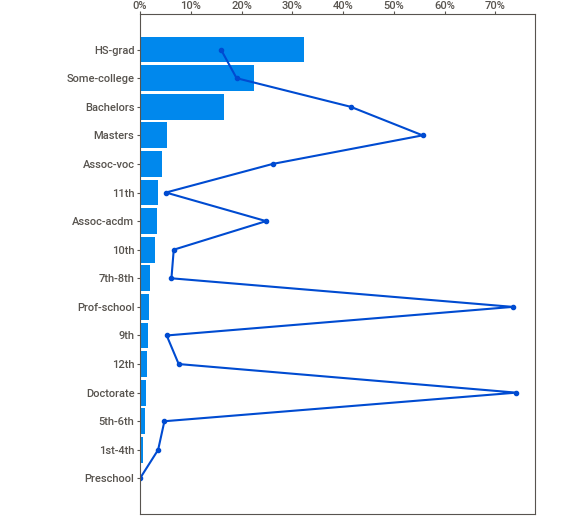
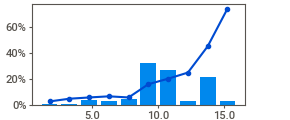
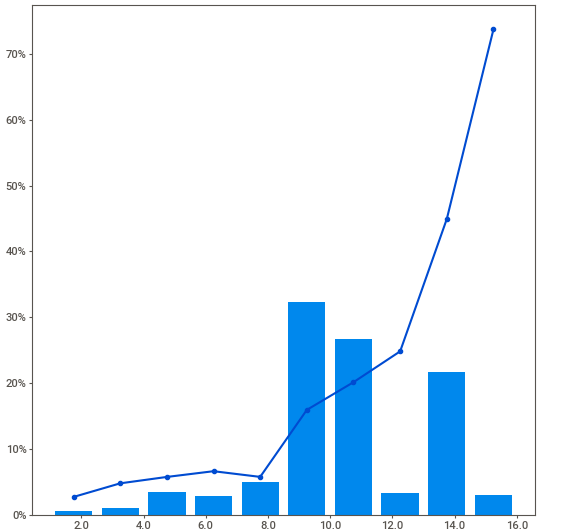
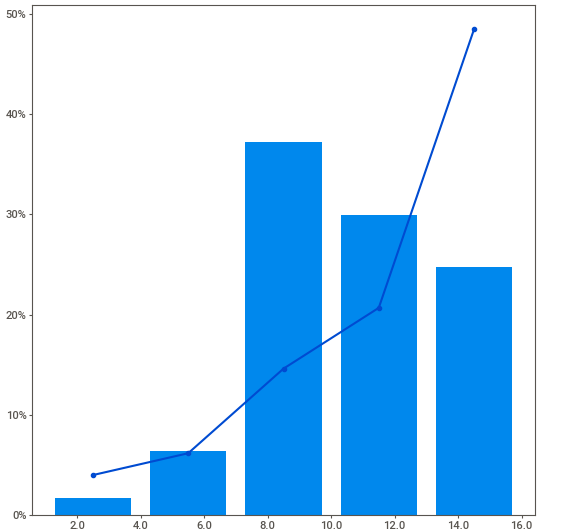
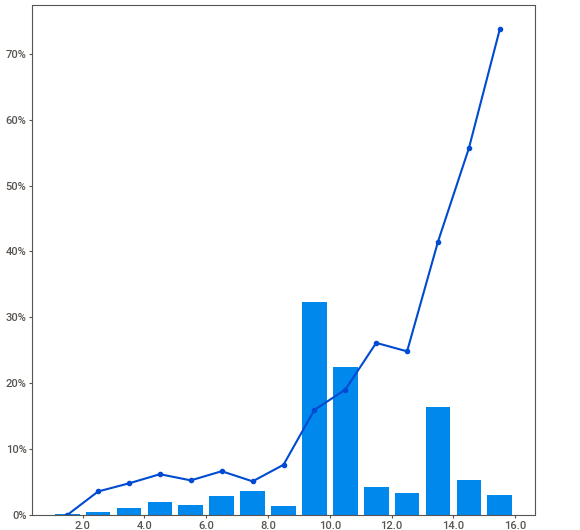
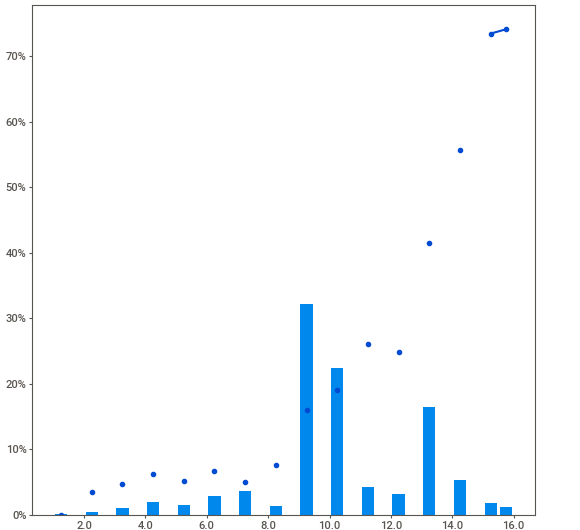
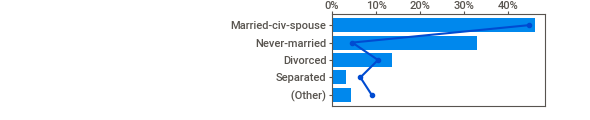
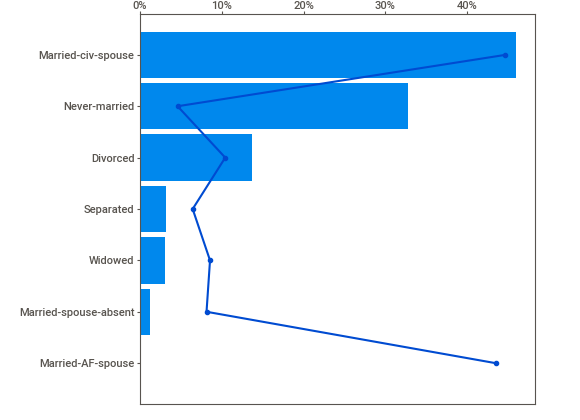
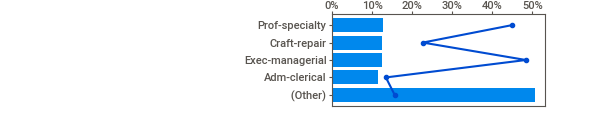
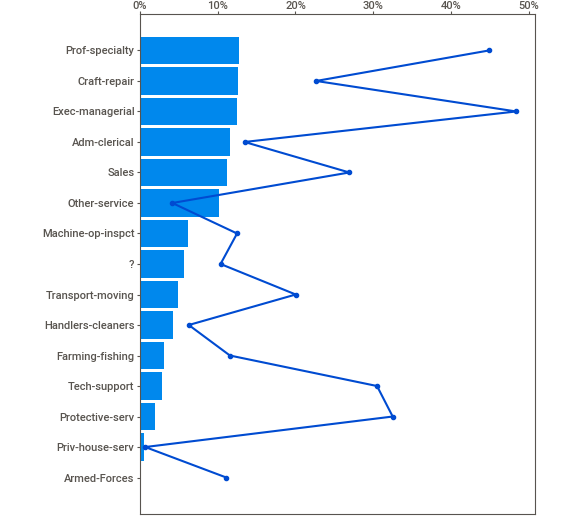
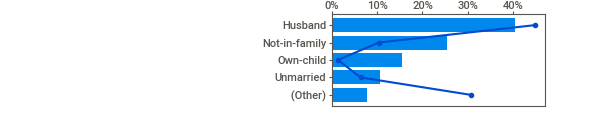
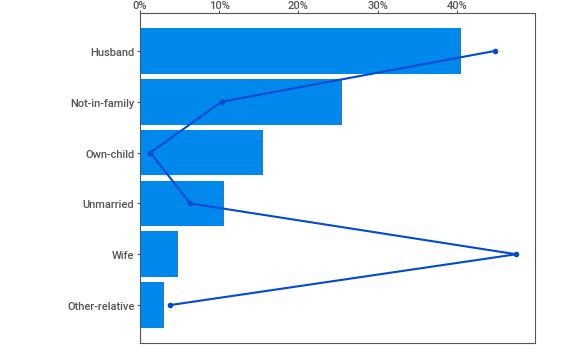
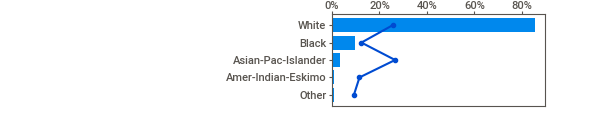
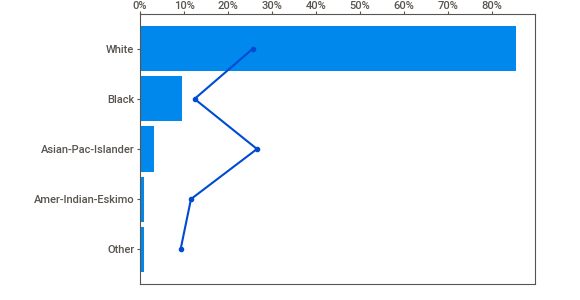
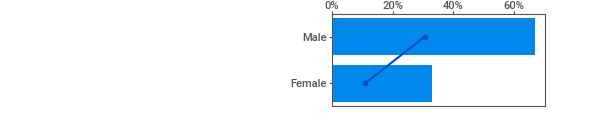
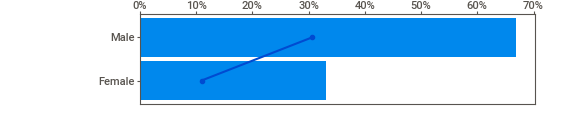
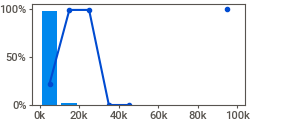
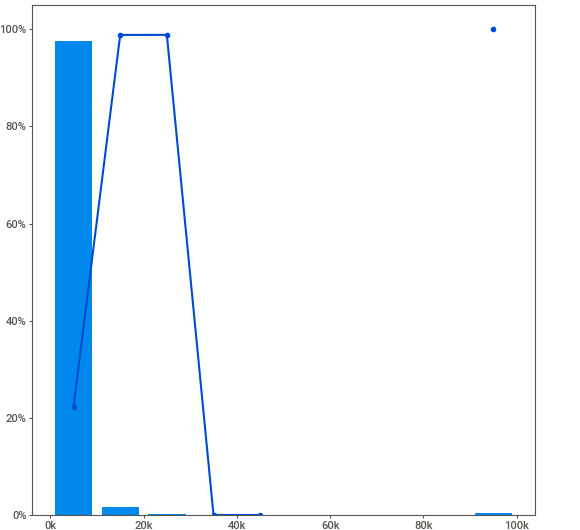
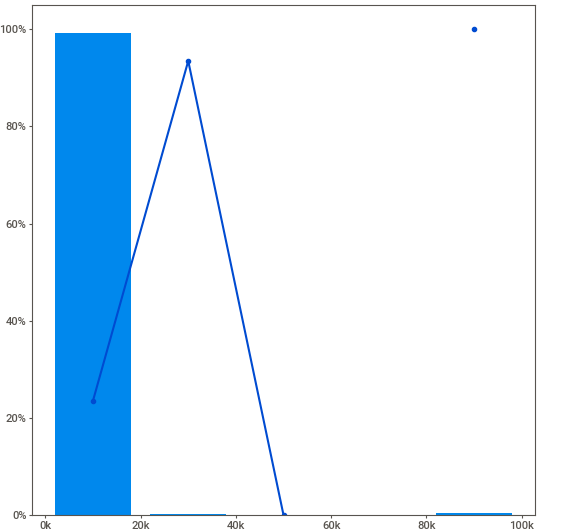
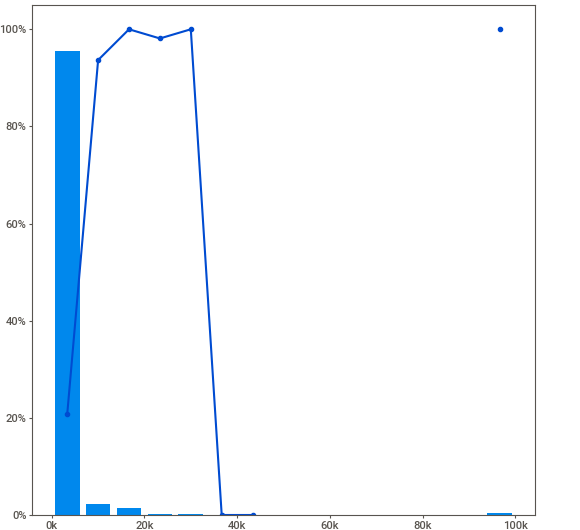
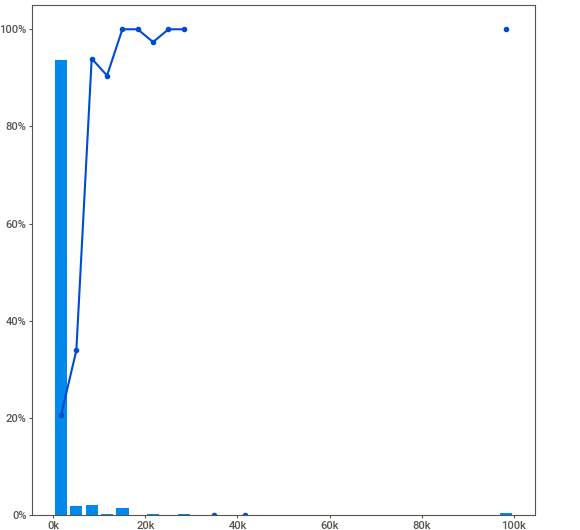
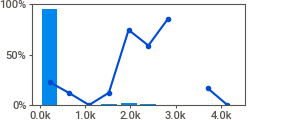
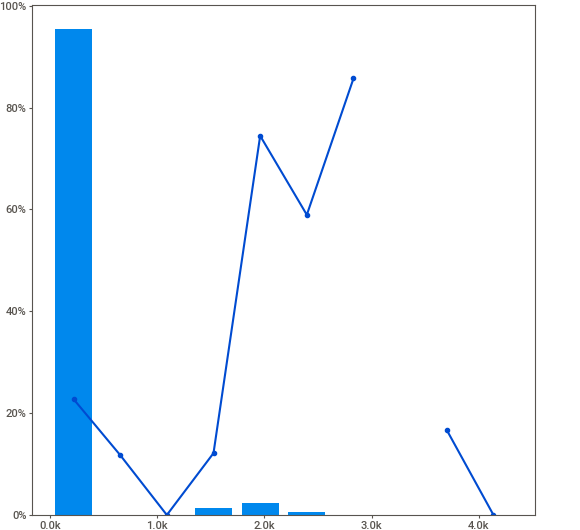
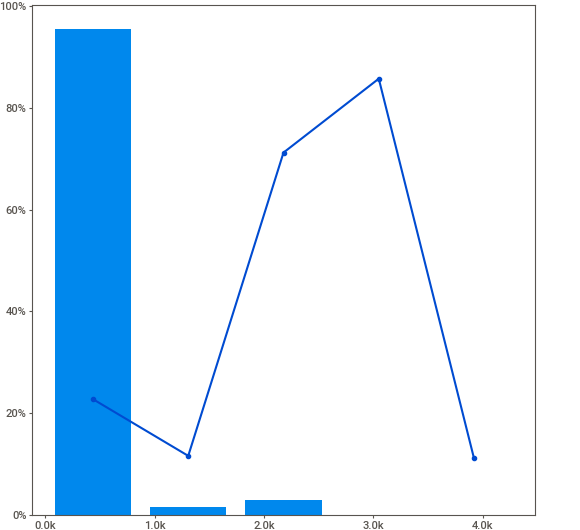
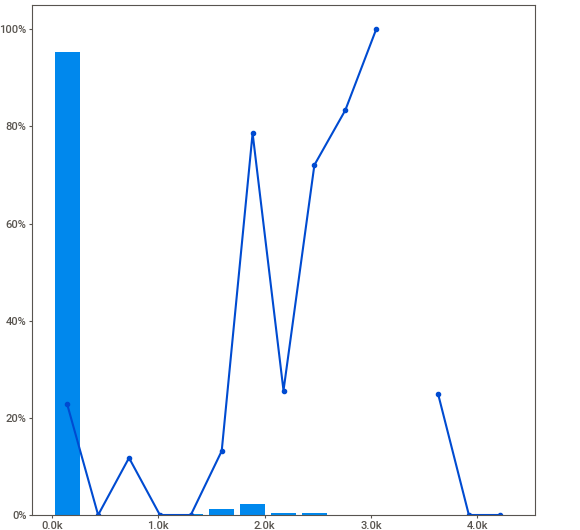
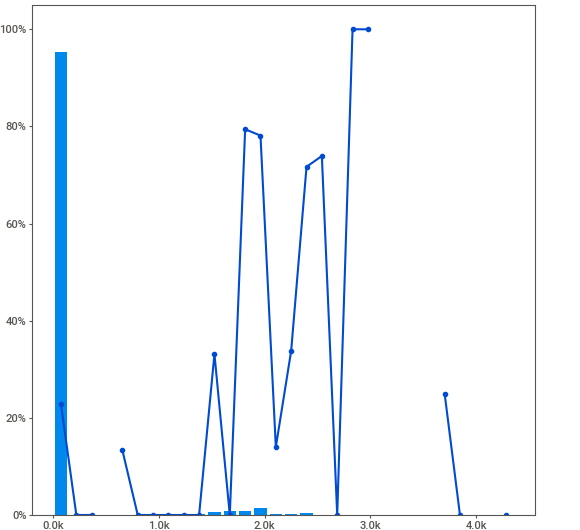
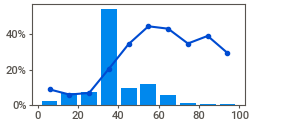
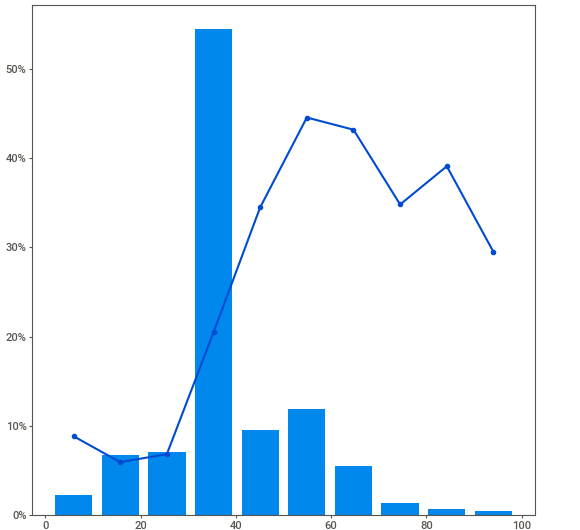
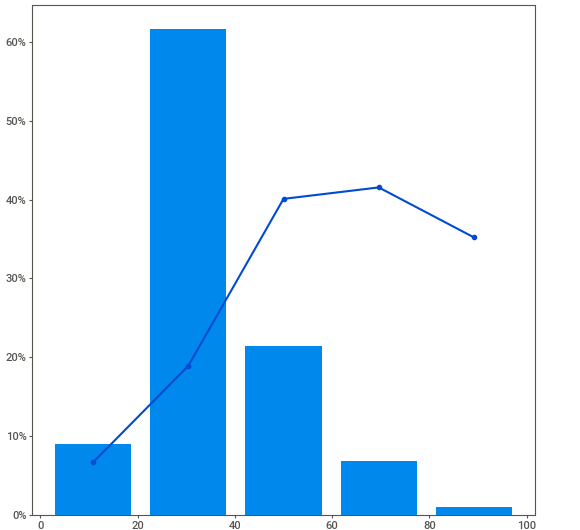
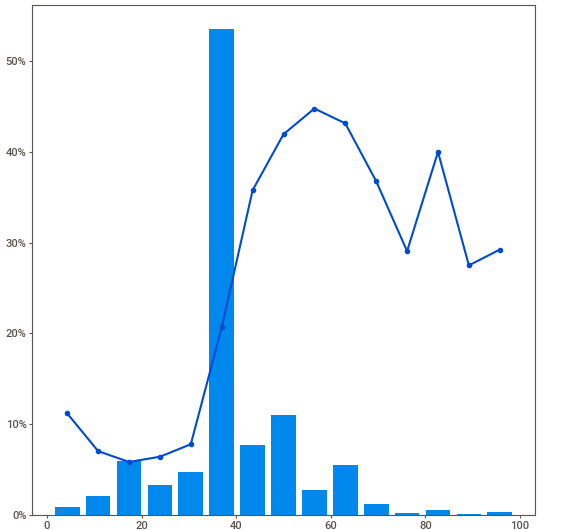
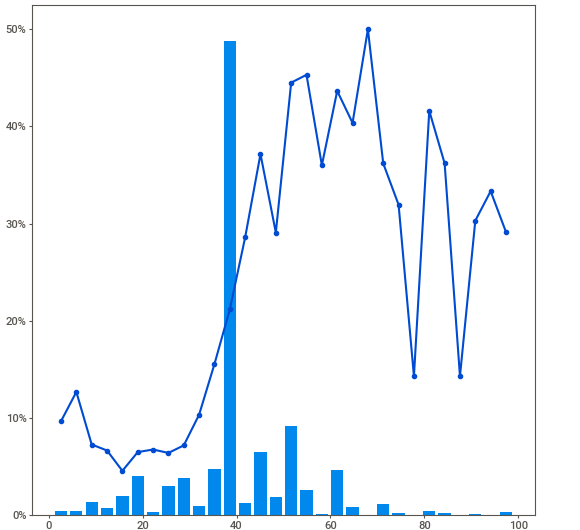
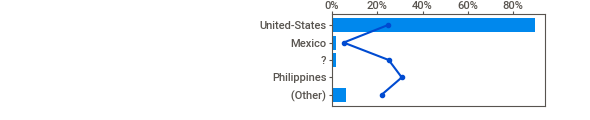
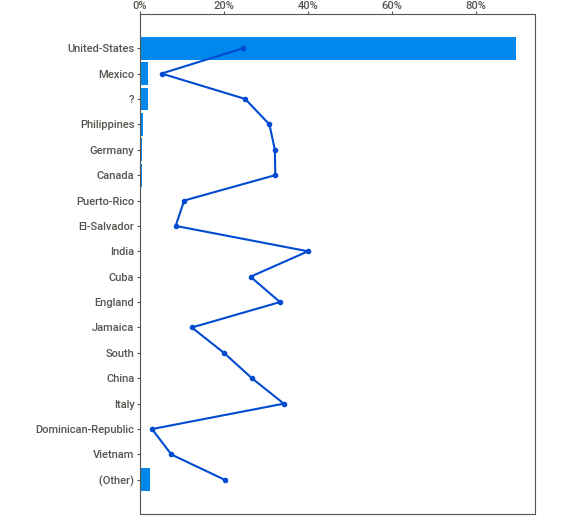
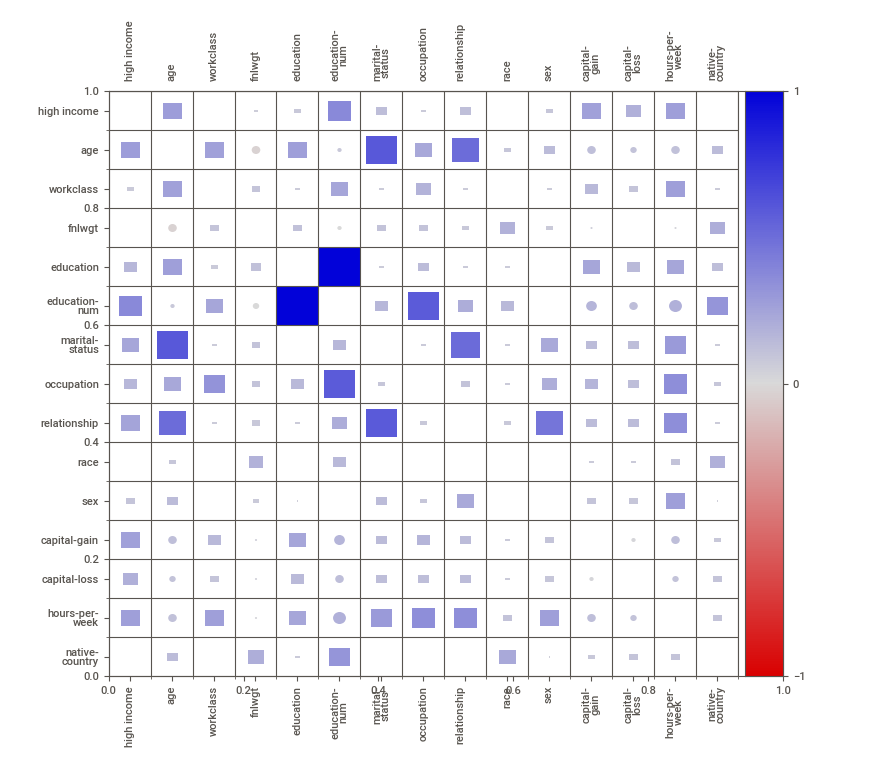
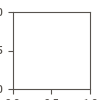

In [11]:
sv.analyze(df_census_income_train, target_feat="high income").show_notebook()

In [12]:
df_census_income_train.drop("fnlwgt", axis=1).duplicated().sum()

3465

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)



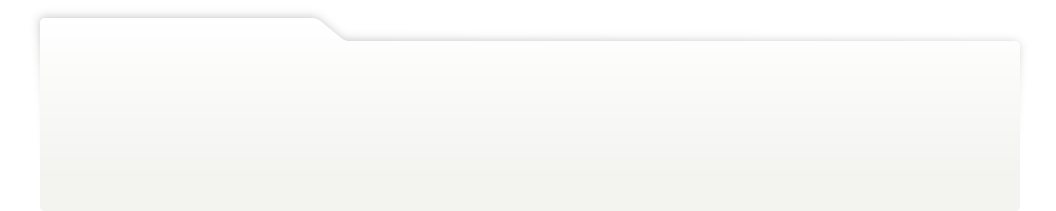
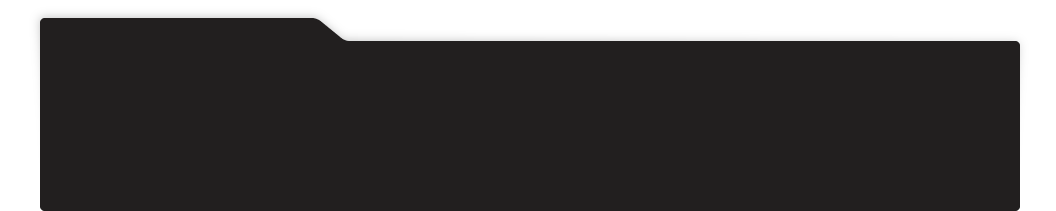
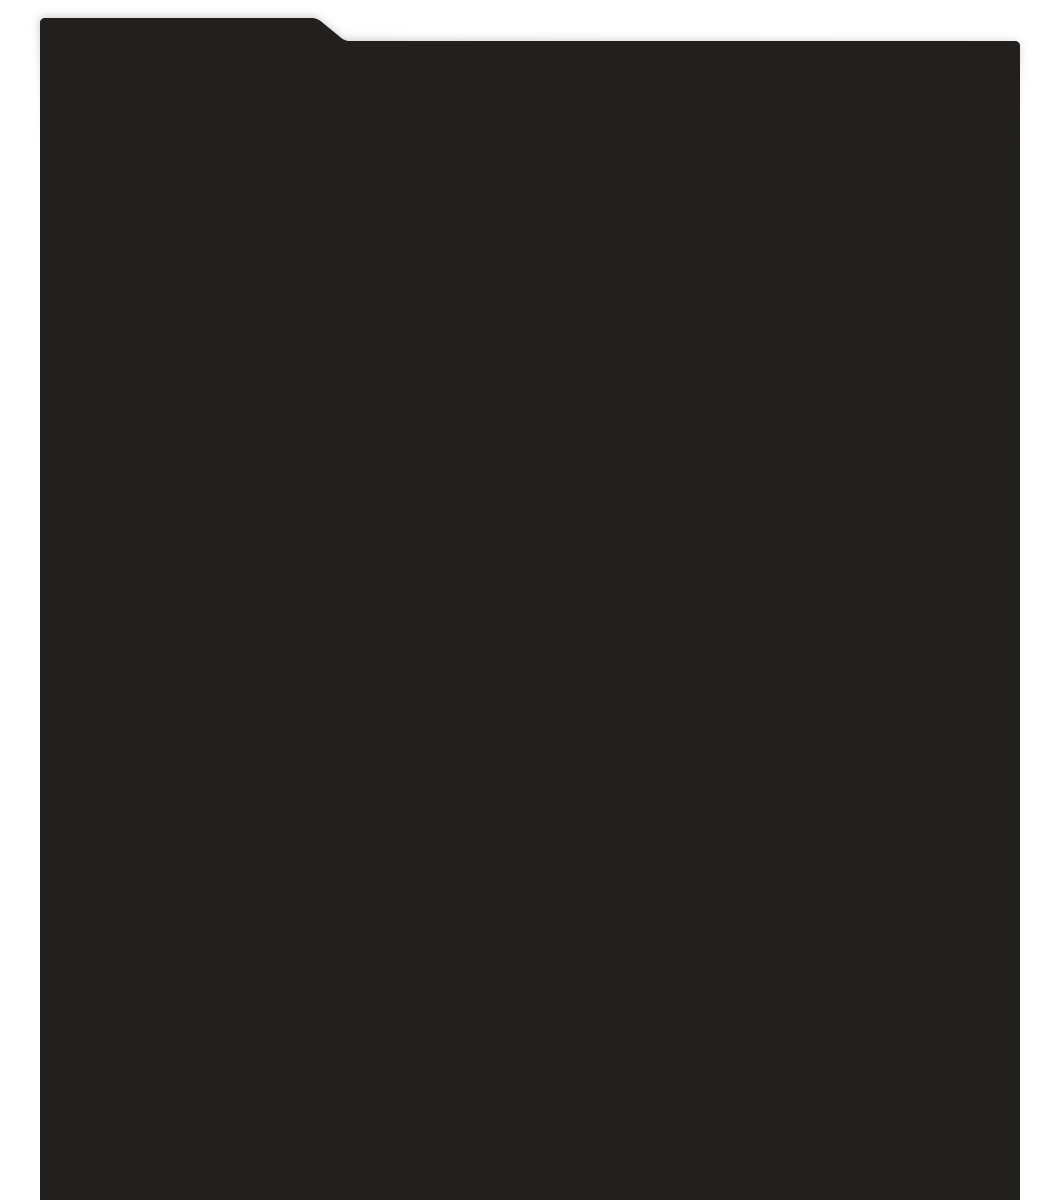
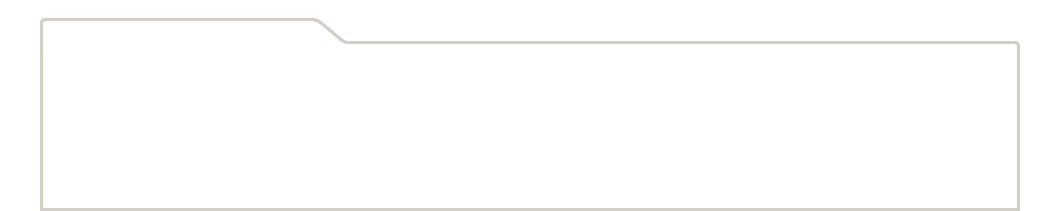
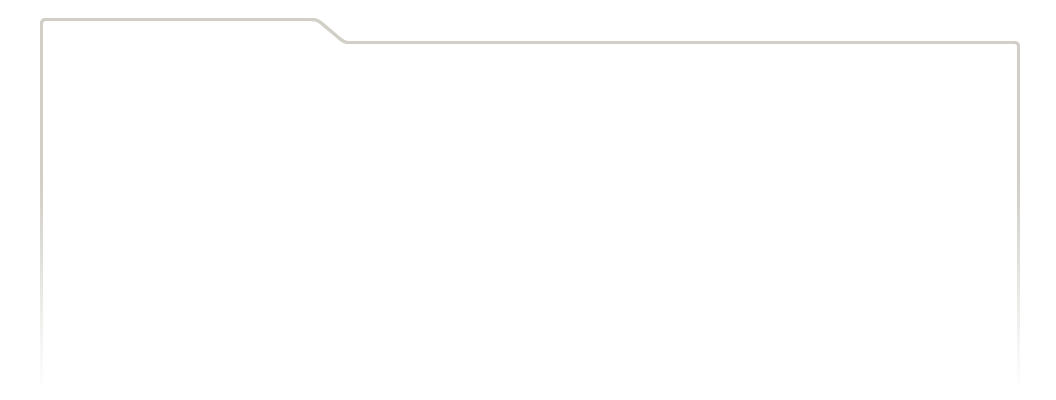
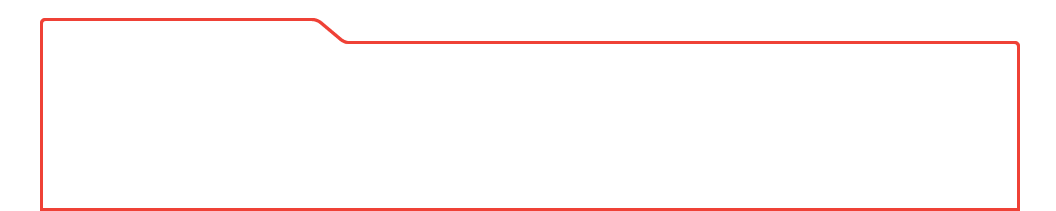
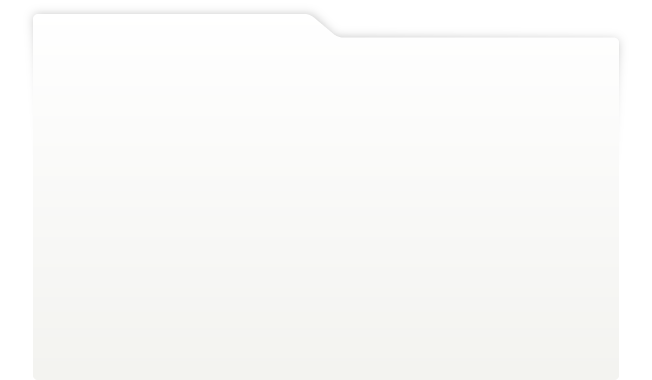
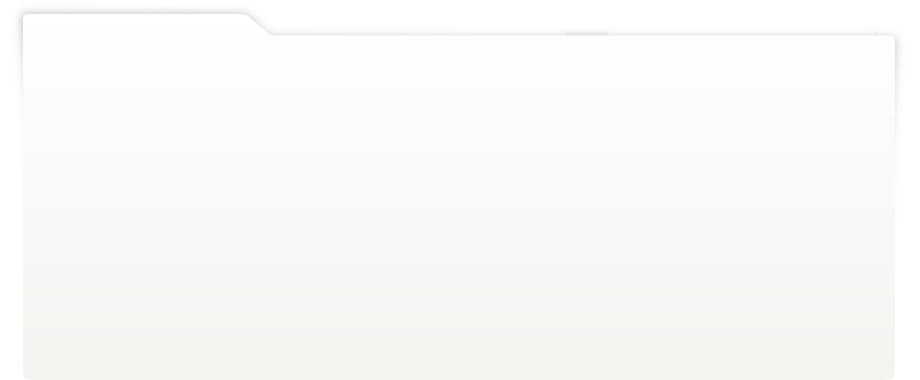
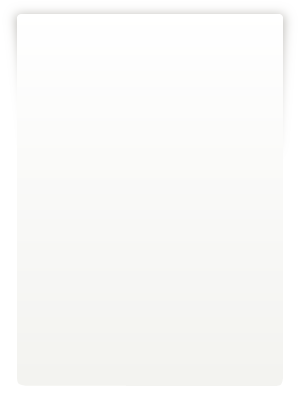
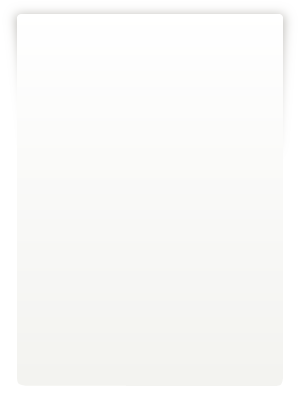
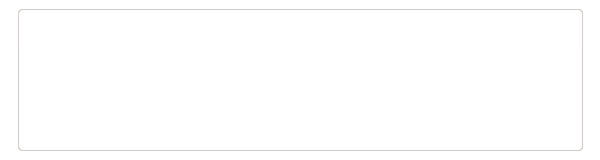
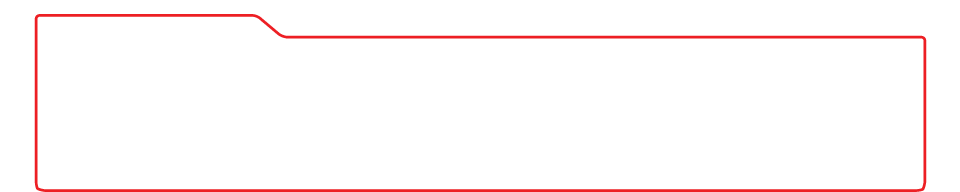
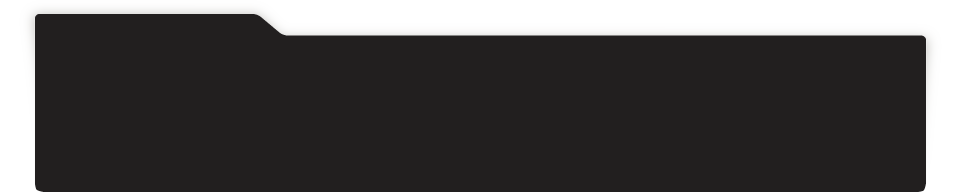
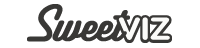
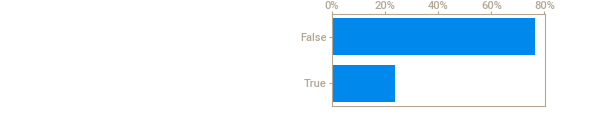
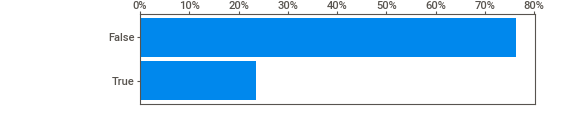
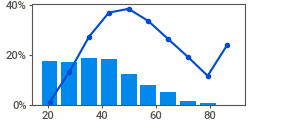
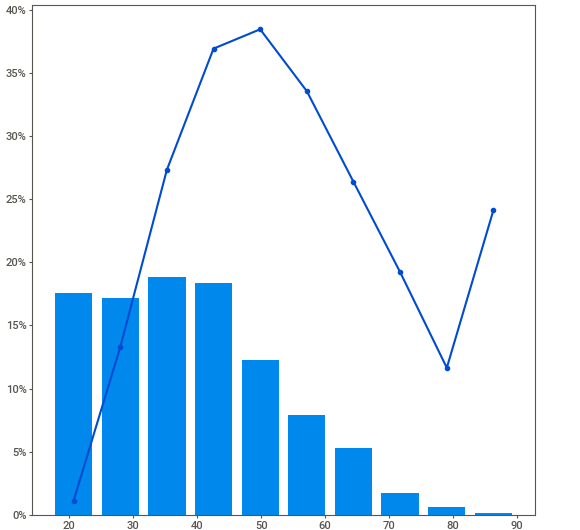
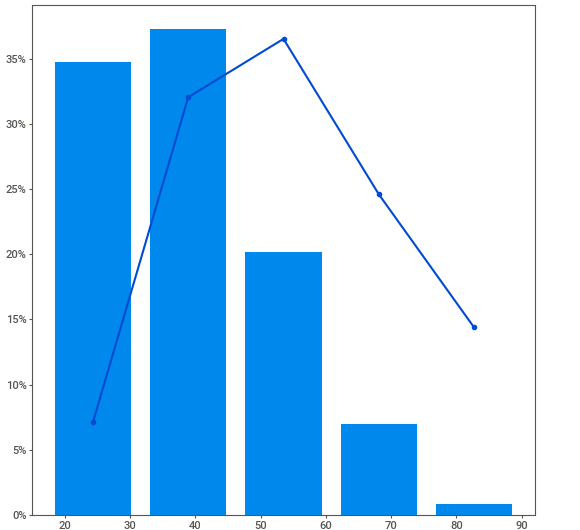
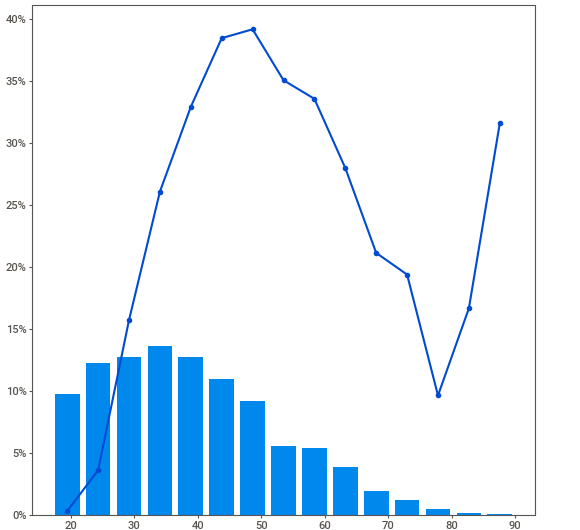
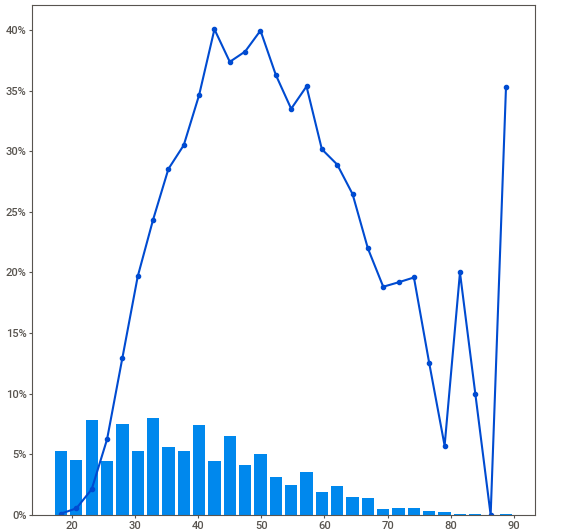
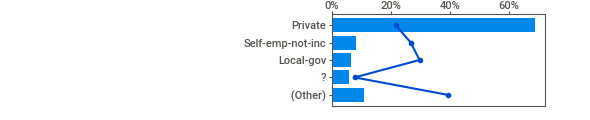
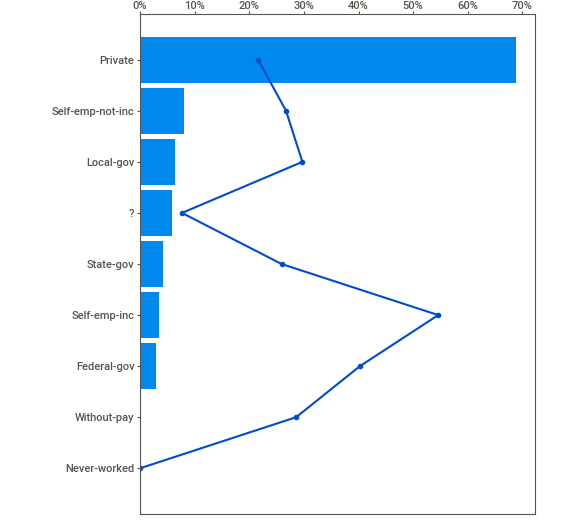
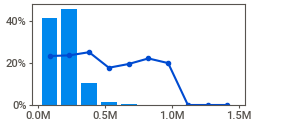
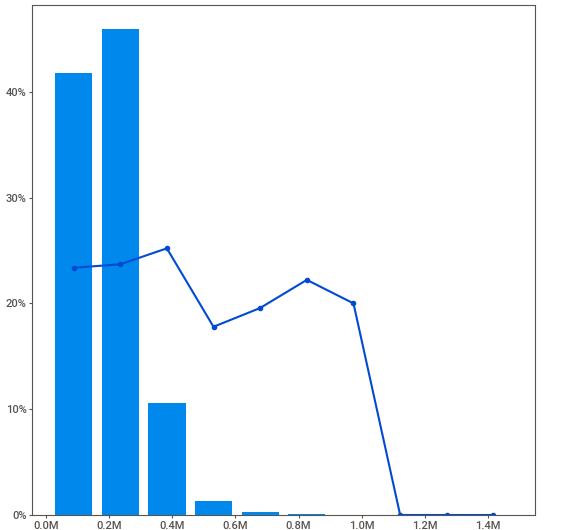
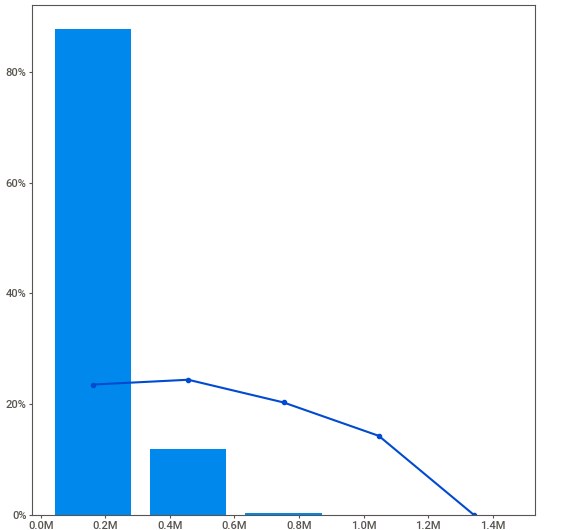
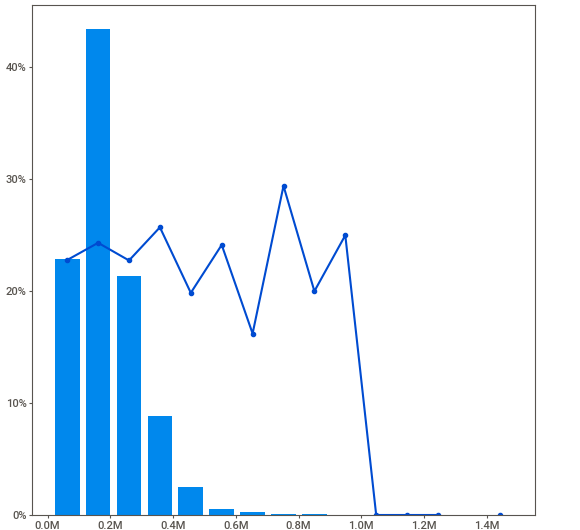
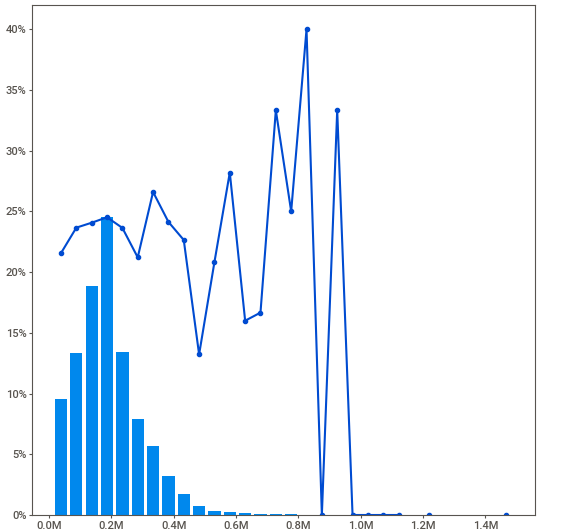
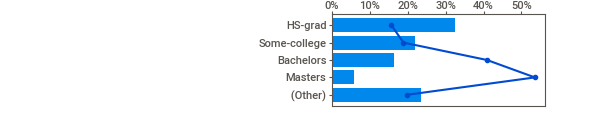
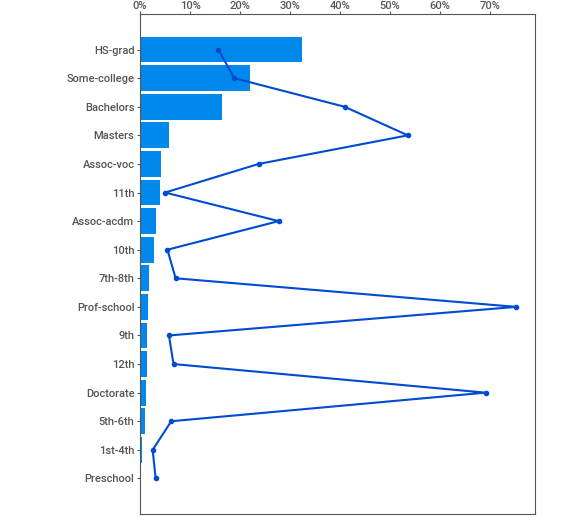
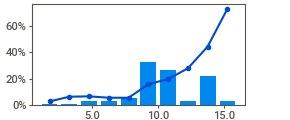
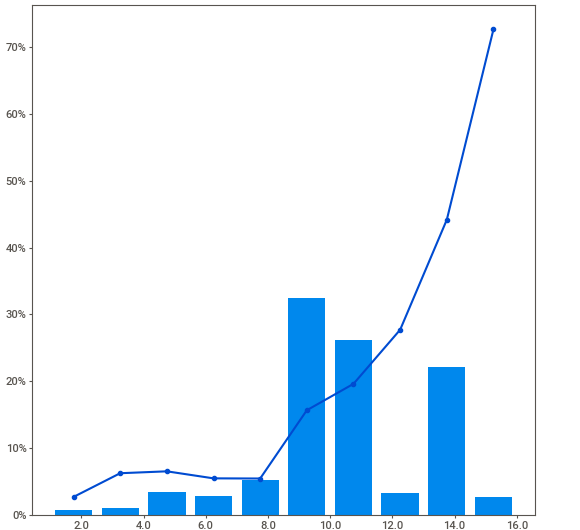
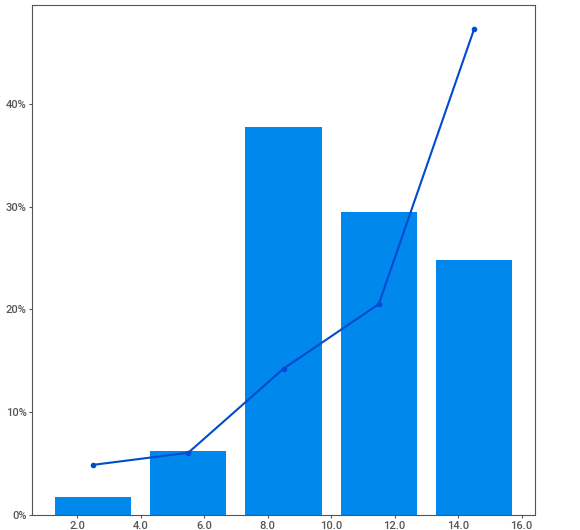
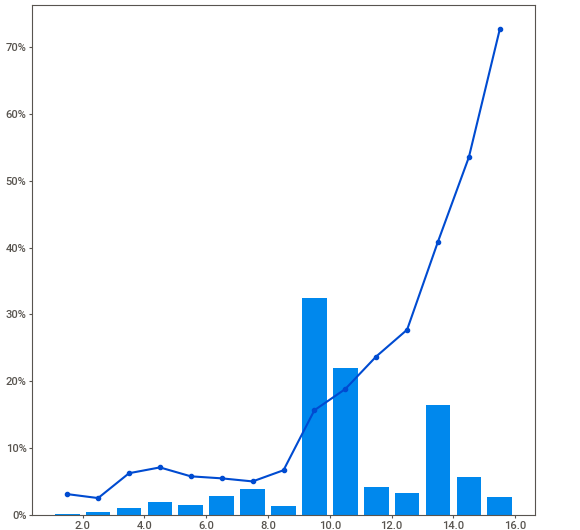
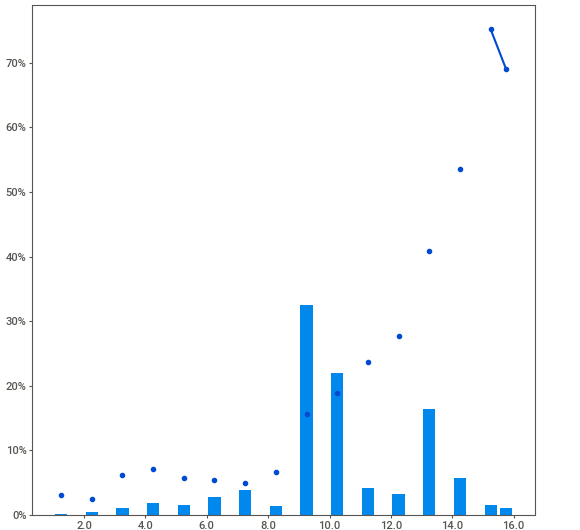
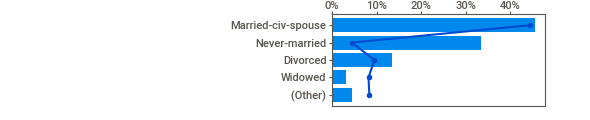
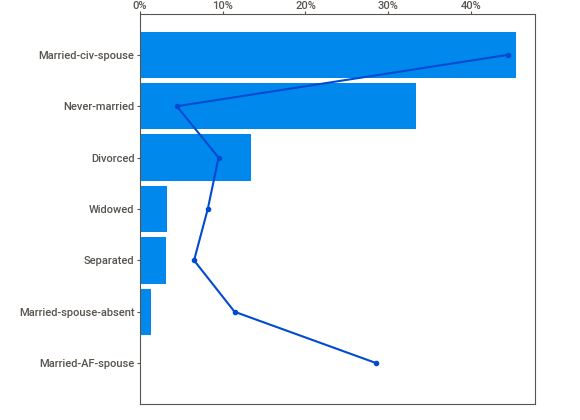
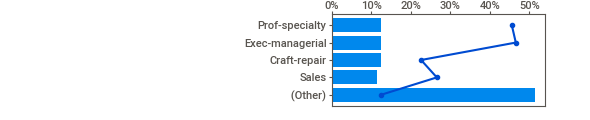
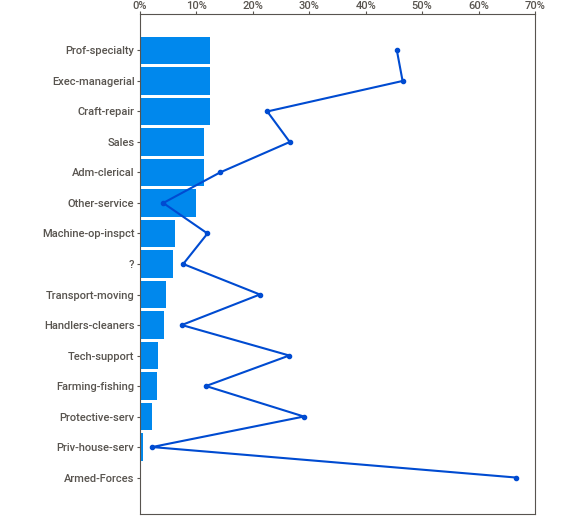
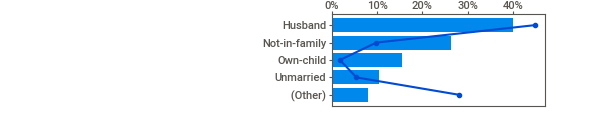
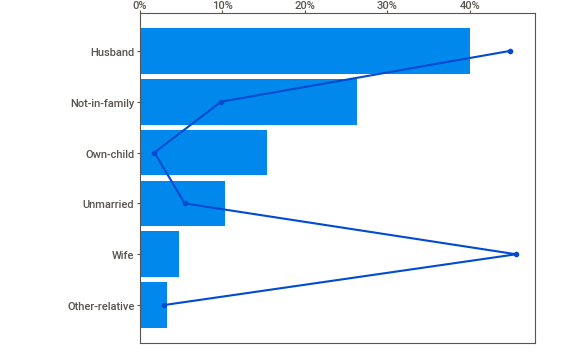
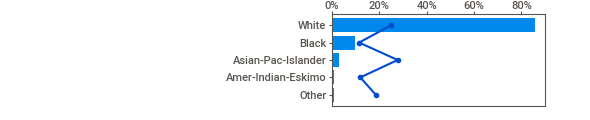
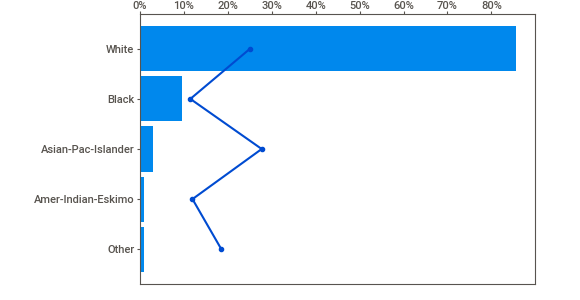
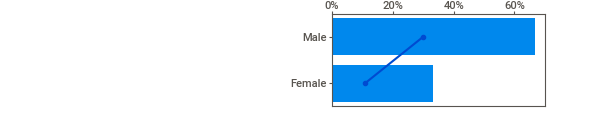
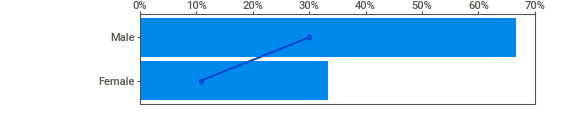
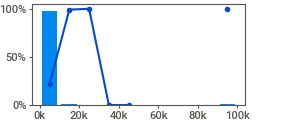
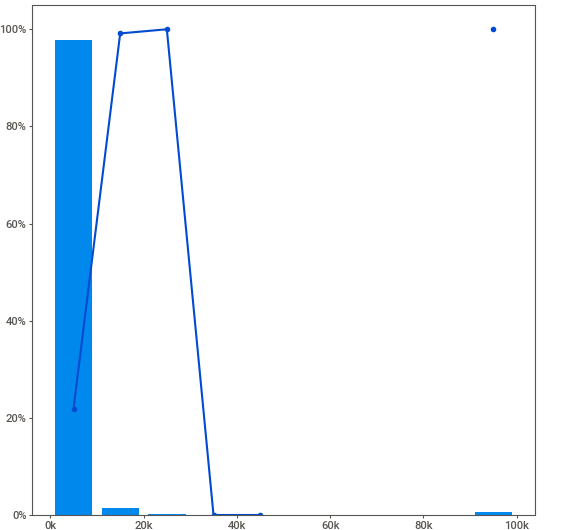
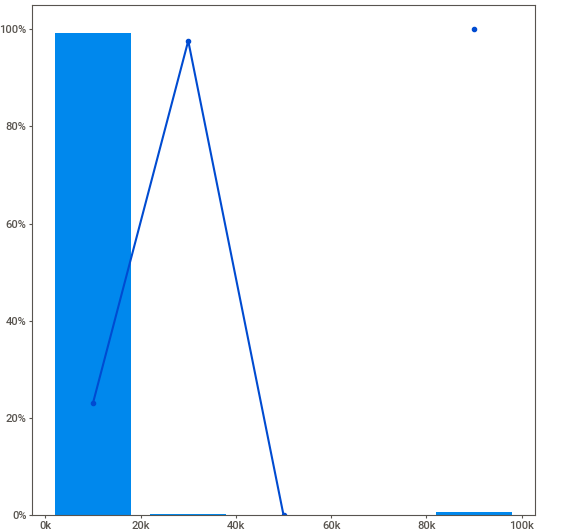
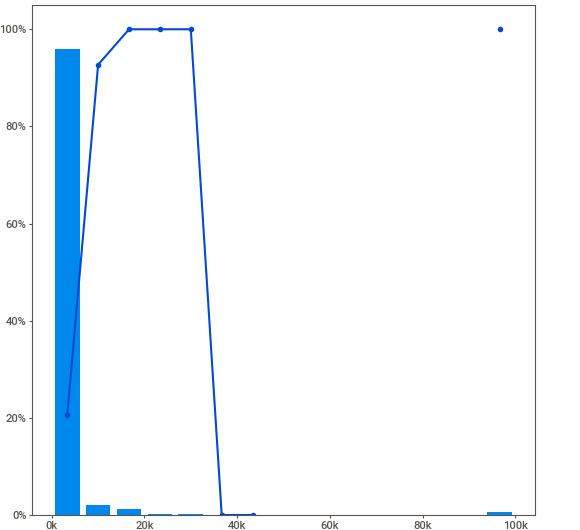
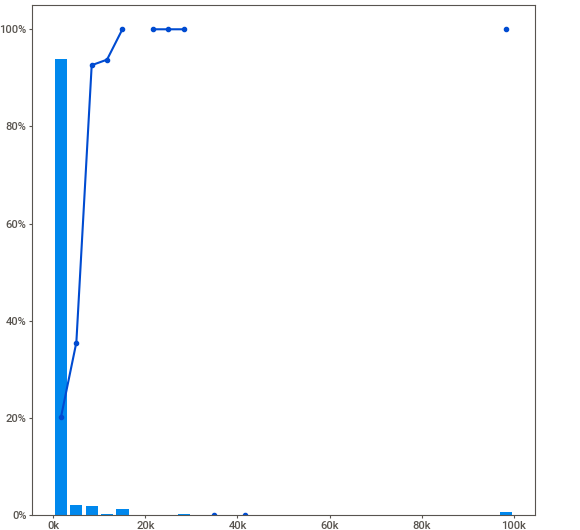
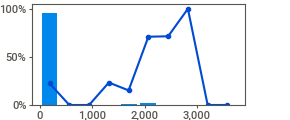
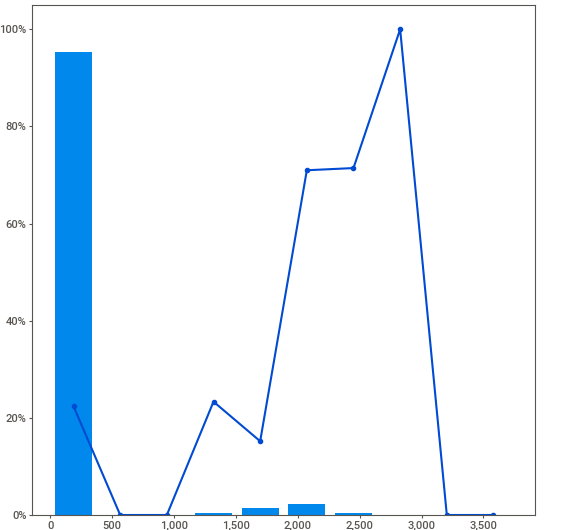
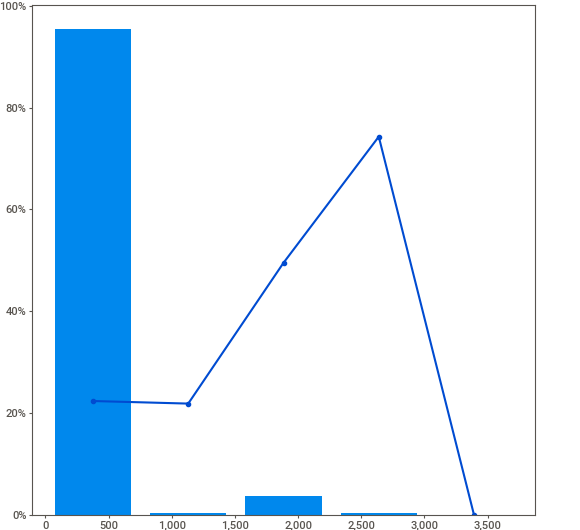
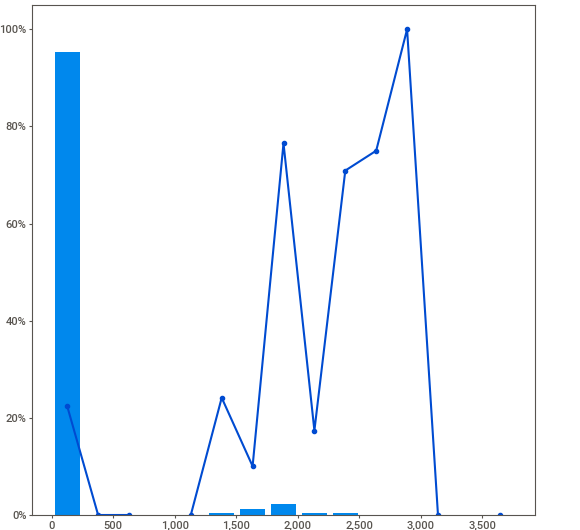
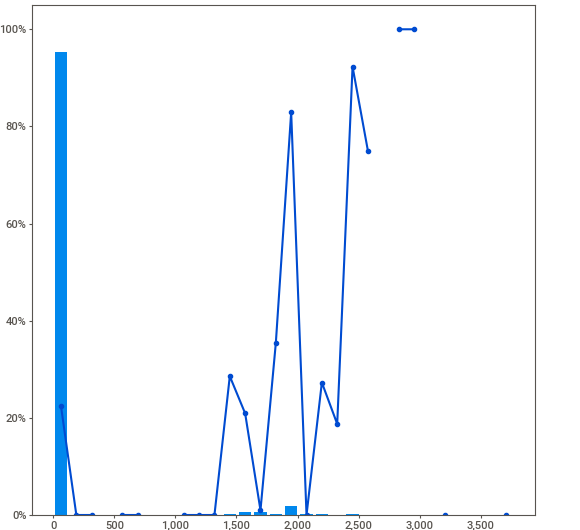
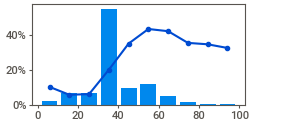
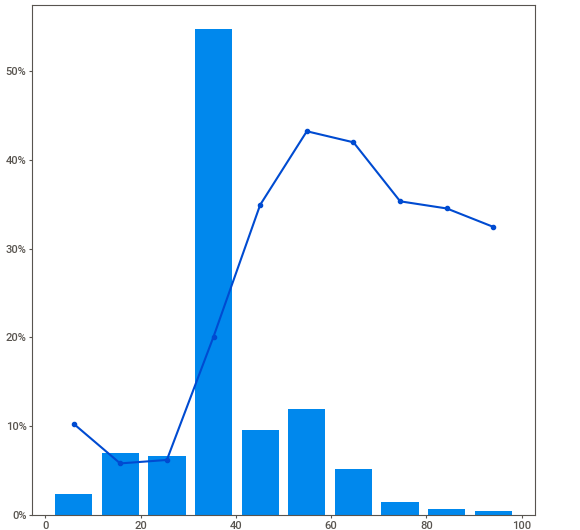
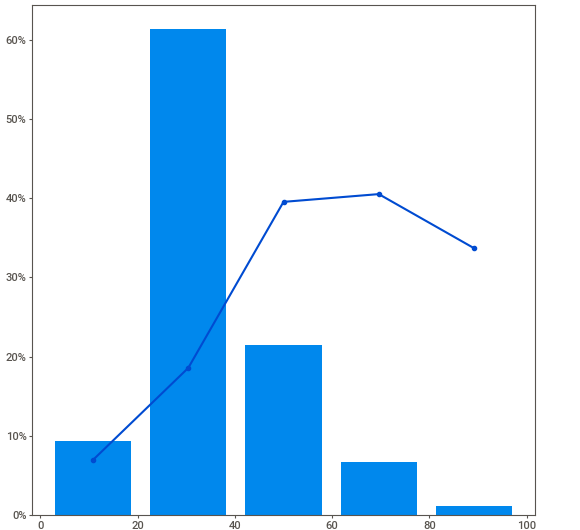
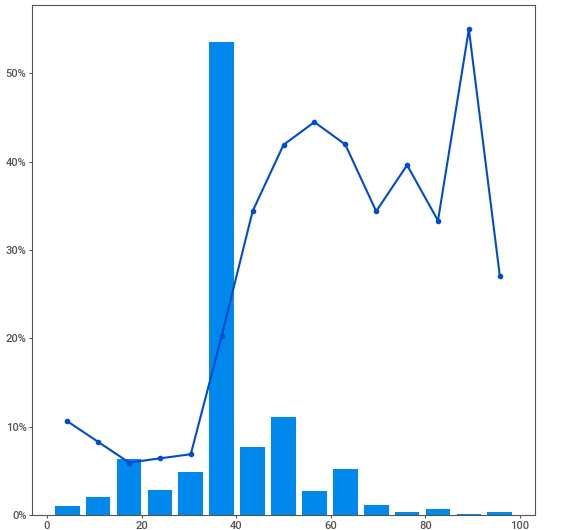
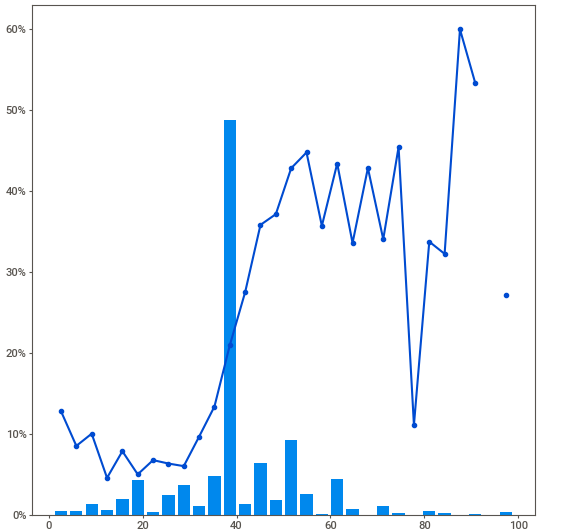
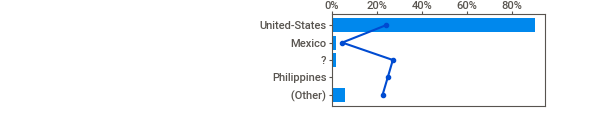
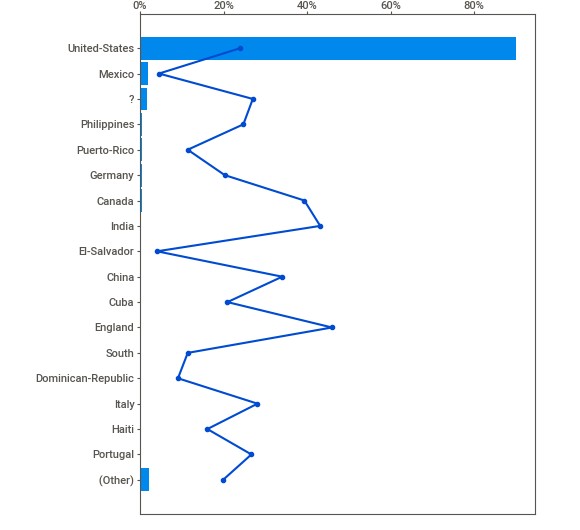
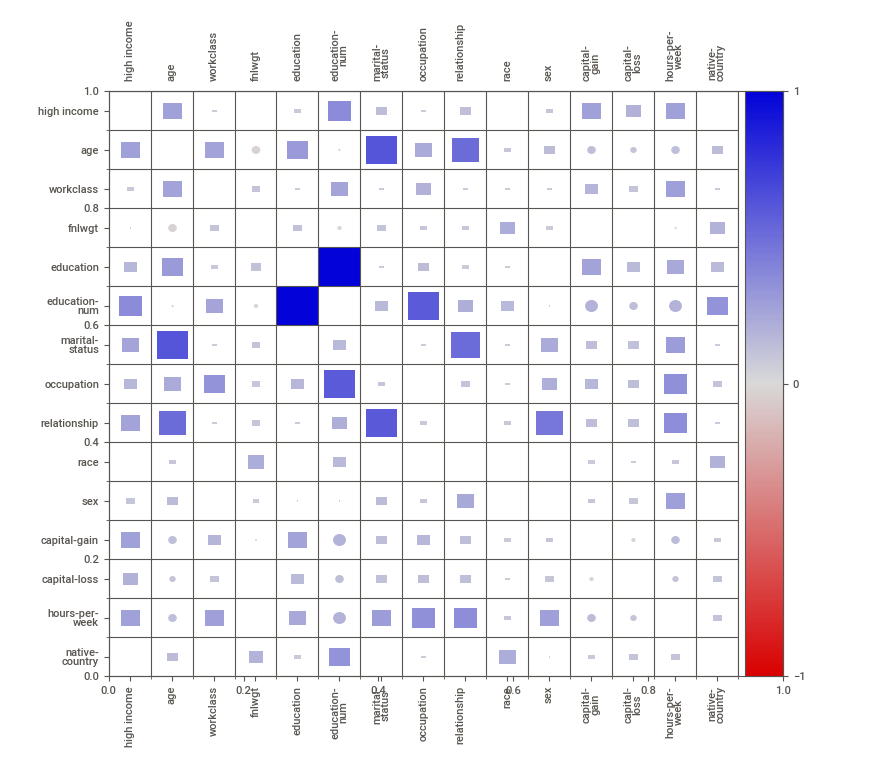
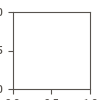

In [13]:
sv.analyze(df_census_income_validation, target_feat="high income").show_notebook()

In [14]:
df_census_income_validation.drop("fnlwgt", axis=1).duplicated().sum()

1022

An aside on data quality: 

There are a few causes for concern regarding the quality of the dataset. To start, let us agree what each row in the dataset represents. It is my understanding that each row should represent a collection of characteristics and the value of "fnlwgt" indicates the number of people which appear in this grouping.

https://cseweb.ucsd.edu/classes/sp15/cse190-c/reports/sp15/048.pdf
https://minds.wisconsin.edu/bitstream/handle/1793/82299/TR1869%20Junda%20Chen%203.pdf

With this interpretation in mind: 
 * We have a handful of duplicates in both the train and validation datasets
 * The number of duplicates increases significantly when we ignore "fnlwgt"
 * The sum of the values in "fnlwgt" is about 6.2 billion, compared to a US population of about 263.4 million and a world population of 5.6 billion in 1994
 * There exist combinations of characteristics which I view to likely be incorrect 
    * 2 instances of sex=Male and relationship=Wife in training data, 1 in validation data
    * 1 instances of sex=Female and relationship=Husband in training data
 * "South" is not a country I am familiar with (native-country)
 * Also worth noting there are missing values in the dataset, however this has been obscured by replacing None or NaN with ? 

Now that we have acknowledged some of the data issues, we will proceed to ignore them. We spent some time investigating as a matter of good practice, however as we are using this data for illustrative purposes only a detailed analysis and selecting a strategy for handling these issues is outside of the scope of this notebook. 




We will partly adapt https://www.kaggle.com/code/yashhvyass/adult-census-income-logistic-reg-explained-86-2 in order to save dev time. This will be useful to return to for further modelling, but right now I am just going to do the bare minimum to test the bias framework

Here is what I would like to do with the data on the basis of the analysis of the data:
Group native-country so it is US vs rest (large number of values with small number of instances, also does not include all values/different set of values between train and validation)
Drop fnlwgt
Drop categorial education in favour of numeric education level  
One hot encode categorical variables


In [ ]:
df_census_income_train["sex"] = df_census_income_train["sex"].apply(lambda x: 1 if x.strip().lower() == "male" else 0)
# According to the graphs in the link provided (and verified below more simply) the dataset is overwhelming white, so group all other races together
# This is also useful since it makes it simpler to compare fairness
df_census_income_train["race"] = df_census_income_train["race"].apply(lambda x: 1 if x.strip().lower() == "white" else 0)
# Similar to race
df_census_income_train["native-country"] = df_census_income_train["native-country"].apply(lambda x: 1 if x.strip().lower() == "united-states" else 0)
df_census_income_train["income"] = df_census_income_train["income"].apply(lambda x: 1 if x.strip().lower() == ">50k" else 0)

# Everything we do to the training data we need to do to the validation data
df_census_income_validation["sex"] = df_census_income_validation["sex"].apply(lambda x: 1 if x.strip().lower() == "male" else 0)
df_census_income_validation["race"] = df_census_income_validation["race"].apply(lambda x: 1 if x.strip().lower() == "white" else 0)
df_census_income_validation["native-country"] = df_census_income_validation["native-country"].apply(lambda x: 1 if x.strip().lower() == "united-states" else 0)
# Turns out this is ever so slightly different from the training set
df_census_income_validation["income"] = df_census_income_validation["income"].apply(lambda x: 1 if x.strip().lower() == ">50k." else 0)


In [ ]:
df_census_income_train["race"].value_counts()

In [ ]:
df_census_income_train["native-country"].value_counts()

In [ ]:
df_census_income_train["income"].value_counts()

In [ ]:
print("Training data percent belonging to class 0:")
print(len(df_census_income_train[df_census_income_train["income"] == 0]) / len(df_census_income_train))
print("Validation data percent belonging to class 0:")
print(len(df_census_income_validation[df_census_income_validation["income"] == 0]) / len(df_census_income_validation))

In [ ]:
print("Training data size", len(df_census_income_train))
print("Validation data size", len(df_census_income_validation))

In [ ]:
# Getting rid of fnlwgt because the description in the kaggle link does not make it sound useful
# Getting rid of education-num since it duplicates education, which we can 1 hot encode
df_census_income_train.drop(columns=["fnlwgt", "education-num"], inplace=True)
df_census_income_validation.drop(columns=["fnlwgt", "education-num"], inplace=True)


In [ ]:
df_census_income_train = pd.get_dummies(df_census_income_train, columns=df_census_income_train.select_dtypes(include=['object']).columns.tolist())
df_census_income_validation = pd.get_dummies(df_census_income_validation, columns=df_census_income_validation.select_dtypes(include=['object']).columns.tolist())

In [ ]:
df_census_income_train.head()

In [ ]:
df_census_income_train_x = df_census_income_train.drop(columns=["income"])
df_census_income_train_y = df_census_income_train["income"]

df_census_income_validation_x = df_census_income_validation.drop(columns=["income"])
df_census_income_validation_y = df_census_income_validation["income"]



In [ ]:
df_census_income_train.head()

In [ ]:
# from sklearn.calibration import CalibratedClassifierCV
random_forest_classifier_1 = RandomForestClassifier(n_estimators=10, max_depth=20, random_state=1)
random_forest_classifier_2 = RandomForestClassifier(n_estimators=10, max_depth=20, random_state=1)

# calibrated_rfc_1 = CalibratedClassifierCV(estimator=random_forest_classifier_1)
# calibrated_rfc_2 = CalibratedClassifierCV(estimator=random_forest_classifier_2)

# calibrated_rfc_1.fit(df_census_income_train_x, df_census_income_train_y)
# proba_1 = calibrated_rfc_1.predict_proba(df_census_income_validation_x)

# calibrated_rfc_2.fit(df_census_income_train_x, df_census_income_train_y)
# proba_2 = calibrated_rfc_2.predict_proba(df_census_income_validation_x)

In [ ]:
# print((proba_1 - proba_2)[:, 1])

In [ ]:

random_forest_bias_1 = Bias_Framework(random_forest_classifier_1, df_census_income_train_x, df_census_income_validation_x, df_census_income_train_y, df_census_income_validation_y)

random_forest_bias_2 = Bias_Framework(random_forest_classifier_2, df_census_income_train_x, df_census_income_validation_x, df_census_income_train_y, df_census_income_validation_y)

In [ ]:
random_forest_bias_1.set_privilege_function(lambda x: x["sex"] == 1 or x["race"] == 1)
random_forest_bias_2.set_privilege_function(lambda x: x["sex"] == 1 or x["race"] == 1)

In [ ]:
random_forest_bias_1.run_framework(seed=1)
results_1 = random_forest_bias_1.get_raw_data()
print("------------------------------------------------------------------------")
random_forest_bias_2.run_framework(seed=1)
results_2 = random_forest_bias_2.get_raw_data()




In [ ]:
# for i in range(len(random_forest_bias_2.probabilities)):
#     print(random_forest_bias_1.probabilities[i] - random_forest_bias_2.probabilities[i])
    
print(random_forest_bias_1.probabilities[0])
print(random_forest_bias_2.probabilities[0])

In [ ]:
for debiasing_method in results_1.keys():
    # if debiasing_method in ["reject option classification statistical parity difference optimised", "reject option classification average odds difference optimised", "reject option classification equal opportunity difference optimised"]:
    #     continue
    for metric_type in results_1[debiasing_method].keys():
        for metric_name in results_1[debiasing_method][metric_type].keys():
            for stat_name in results_1[debiasing_method][metric_type][metric_name].keys():
                if stat_name == "confidence interval" or stat_name == "quartiles":
                    continue
                difference = results_1[debiasing_method][metric_type][metric_name][stat_name] - results_2[debiasing_method][metric_type][metric_name][stat_name]
                if difference > 0.00001:
                    print(difference, debiasing_method, metric_type, metric_name, stat_name)
                


# results_1.keys()



In [ ]:
random_forest_bias_1.get_DebiasingGraphsObject().show_single_graph("accuracy", "statistical parity difference")